In [3]:
# Initialize dotenv, Supabase client, and plotting defaults
import os
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
from supabase import create_client
from concurrent.futures import ThreadPoolExecutor
from dotenv import load_dotenv

load_dotenv()
supabase_url = os.environ['SUPABASE_URL']
supabase_key = os.environ['SUPABASE_KEY']
bucket = os.getenv('SUPABASE_BUCKET', '3d-assets')
metadata_prefix = 'metadata'
client = create_client(supabase_url, supabase_key)
public_root = f"{supabase_url}/storage/v1/object/public/{bucket}"
plt.style.use('seaborn-v0_8-darkgrid')

In [4]:
# Page through Supabase storage to collect metadata JSON file names
metadata_files = []
offset = 0
limit = 1000

while True:
    batch = client.storage.from_(bucket).list(metadata_prefix, {'limit': limit, 'offset': offset})
    if not batch:
        break
    metadata_files.extend([f for f in batch if f['name'].endswith('.json')])
    if len(batch) < limit:
        break
    offset += limit

len(metadata_files)

597

In [5]:
# Download metadata files in parallel and build a pandas DataFrame
records = []

def _fetch_metadata(entry):
    name = entry['name']
    url = f"{public_root}/{metadata_prefix}/{name}"
    resp = requests.get(url, timeout=20)
    resp.raise_for_status()
    data = resp.json()
    annotations = data['annotations']
    bbox = data['assetMetadata']['boundingBox']
    return {
        'asset': name.replace('.json', ''),
        'category': annotations['category'],
        'description': annotations['description'],
        'width': annotations['width'],
        'depth': annotations['depth'],
        'height': annotations['height'],
        'volume': annotations['volume'],
        'mass': annotations['mass'],
        'z_axis_scale': annotations['z_axis_scale'],
        'pose_z_rot_angle': annotations['pose_z_rot_angle'],
        'frontView': annotations['frontView'],
        'onFloor': annotations['onFloor'],
        'onWall': annotations['onWall'],
        'onCeiling': annotations['onCeiling'],
        'onObject': annotations['onObject'],
        'materials': annotations['materials'],
        'composition': annotations['composition'],
        'bbox_x': bbox['x'],
        'bbox_y': bbox['y'],
        'bbox_z': bbox['z']
    }

with ThreadPoolExecutor(max_workers=16) as pool:
    records = list(pool.map(_fetch_metadata, metadata_files))

df = pd.DataFrame(records)
df.head()


,asset,category,description,width,depth,height,volume,mass,z_axis_scale,pose_z_rot_angle,frontView,onFloor,onWall,onCeiling,onObject,materials,composition,bbox_x,bbox_y,bbox_z
0,accent_chairs_1,Furniture,"Mainstays Boucle Swivel Accent Chair, Taupe",0.8128,0.1016,0.762,0.0624,25.855,True,0.0,0,True,False,False,False,"[Boucle fabric, Wood, Metal]","[0.333, 0.333, 0.334]",0.8382,0.8128,0.762
1,accent_chairs_10,Furniture,"PAPROOS Mid-Century Modern Accent Chair, PU Le...",0.7700,0.6500,0.740,0.3704,113.398,True,0.0,0,True,False,False,False,"[PU Leather, Wood, Sponge]","[0.333, 0.333, 0.334]",0.6500,0.7700,0.740
2,accent_chairs_11,Accent Chair,Elegant Upholstery: Stain-treated boucle fabri...,1.0400,0.9200,0.790,0.7559,50.900,True,0.0,0,True,False,False,False,[],[],1.0400,0.9200,0.790
3,accent_chairs_12,Furniture,"Bezseller Modern Accent Chair, Upholstered Arm...",0.7750,0.7620,0.829,0.4896,18.144,True,0.0,0,True,False,False,False,"[Terry fabric, Wood, Sponge, Chenille]","[0.25, 0.25, 0.25, 0.25]",0.7750,0.7750,0.829
4,accent_chairs_13,Furniture,Introduce the Mainstays Swivel Chair to your l...,0.8128,0.1016,0.762,0.0617,25.855,True,0.0,0,True,False,False,False,[],[],0.8382,0.8128,0.762


In [6]:
# Derive volume metrics and inspect numeric summaries
df['computed_volume'] = df['width'] * df['depth'] * df['height']
df['bbox_volume'] = df['bbox_x'] * df['bbox_y'] * df['bbox_z']
df['bbox_ratio_x'] = df['bbox_x'] / df['width']
df['bbox_ratio_y'] = df['bbox_y'] / df['depth']
df['bbox_ratio_z'] = df['bbox_z'] / df['height']

df[['width', 'depth', 'height', 'mass', 'volume', 'computed_volume']].describe().round(4)

,width,depth,height,mass,volume,computed_volume
count,597.0000,597.0000,597.0000,464.0000,597.0000,597.0000
mean,1.1158,0.7802,0.7925,41.6798,0.7937,0.8107
std,0.7872,0.5738,0.4135,50.2565,1.1464,1.1380
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.5334,0.3962,0.5000,12.5700,0.1360,0.1593
50%,0.8542,0.6000,0.8128,27.2155,0.3093,0.3210
75%,1.5000,0.9144,1.0000,45.7600,0.7733,0.7733
max,4.4481,3.0480,2.1847,408.2300,4.7355,4.7355


In [7]:
# Inspect z-axis scale and pose rotation annotations
orientation_cols = ['z_axis_scale', 'pose_z_rot_angle']
orientation_stats = df[orientation_cols].describe().round(4)
orientation_stats


,pose_z_rot_angle
count,597.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


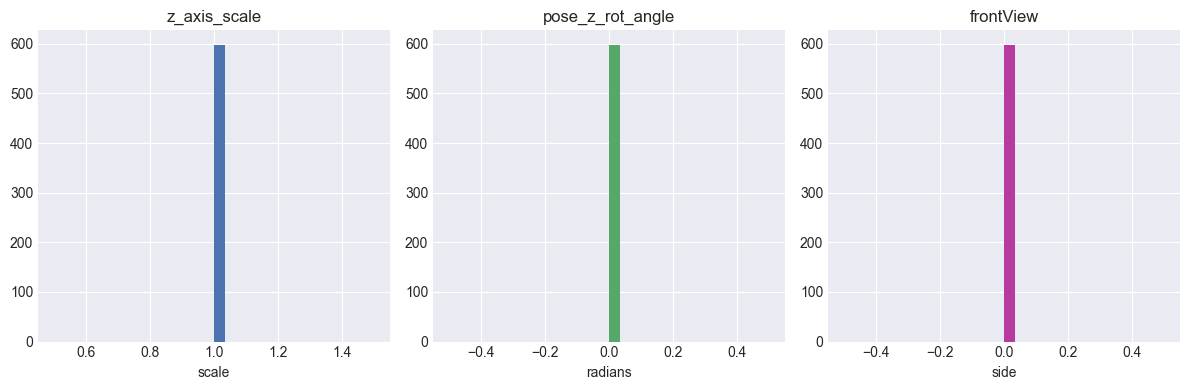

In [27]:
# Visualize distribution for z-axis scale and pose rotation
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
df['z_axis_scale'].dropna().hist(ax=axes[0], bins=30, color='#4c72b0')
axes[0].set_title('z_axis_scale')
axes[0].set_xlabel('scale')
df['pose_z_rot_angle'].dropna().hist(ax=axes[1], bins=30, color='#55a868')
axes[1].set_title('pose_z_rot_angle')
axes[1].set_xlabel('radians')
df['frontView'].dropna().hist(ax=axes[2], bins=30, color="#b73aa0")
axes[2].set_title('frontView')
axes[2].set_xlabel('side')
plt.tight_layout()
plt.show()


In [9]:
# Quick counts for rows and categories
total_assets = len(df)
unique_categories = df['category'].nunique()
total_assets, unique_categories

(597, 28)

In [10]:
# Count assets per category to reuse downstream
category_counts = df['category'].value_counts().sort_values(ascending=False)

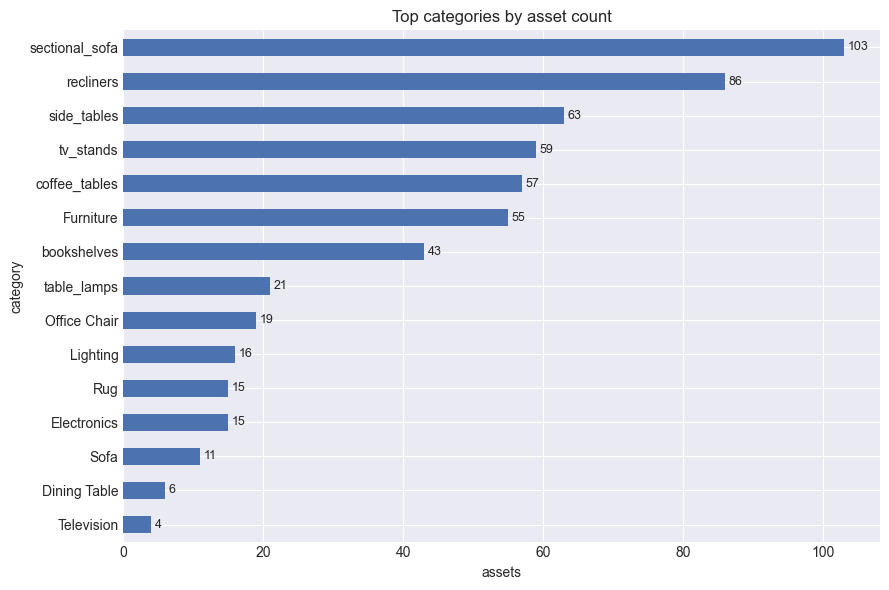

In [11]:
# Visualize the most common categories with inline counts

top_categories = category_counts.head(15).iloc[::-1]
ax = top_categories.plot(kind='barh', figsize=(9, 6), color='#4c72b0')
for idx, value in enumerate(top_categories):
    ax.text(value + 0.5, idx, int(value), va='center', fontsize=9)
ax.set_title('Top categories by asset count')
ax.set_xlabel('assets')
ax.set_ylabel('category')
plt.tight_layout()
plt.show()


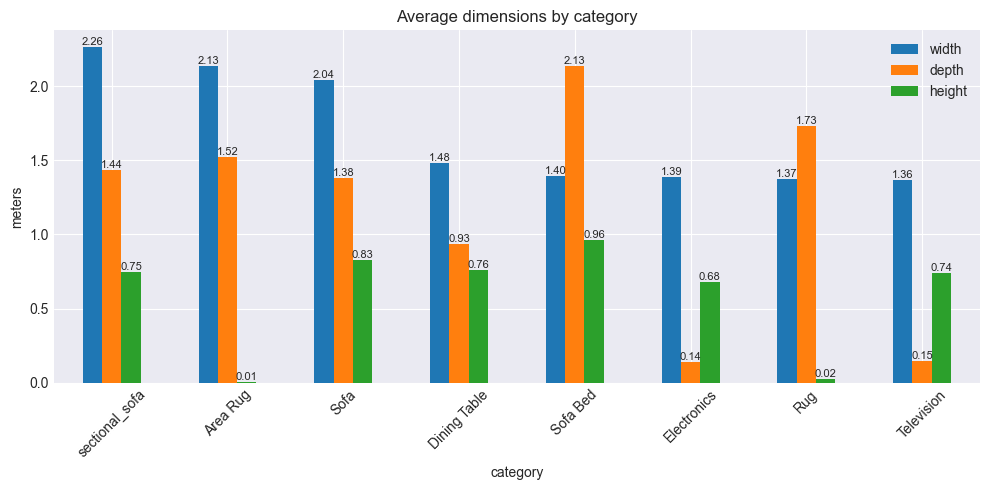

In [12]:
# Compare average width/depth/height per category

dim_summary = (
    df.groupby('category')[['width', 'depth', 'height', 'mass']]
    .mean()
    .round(3)
    .sort_values('width', ascending=False)
)
top_dims = dim_summary.head(8)
ax = top_dims[['width', 'depth', 'height']].plot(kind='bar', figsize=(10, 5), rot=45)
for patch in ax.patches:
    height = patch.get_height()
    if pd.notnull(height):
        ax.annotate(f"{height:.2f}", (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=8)
ax.set_ylabel('meters')
ax.set_title('Average dimensions by category')
plt.tight_layout()
plt.show()


/var/folders/7w/8tj21nwn4ml3r6z3ylzqzmdc0000gn/T/ipykernel_18918/2633102542.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbox_means['mean_size'] = bbox_means.mean(axis=1)


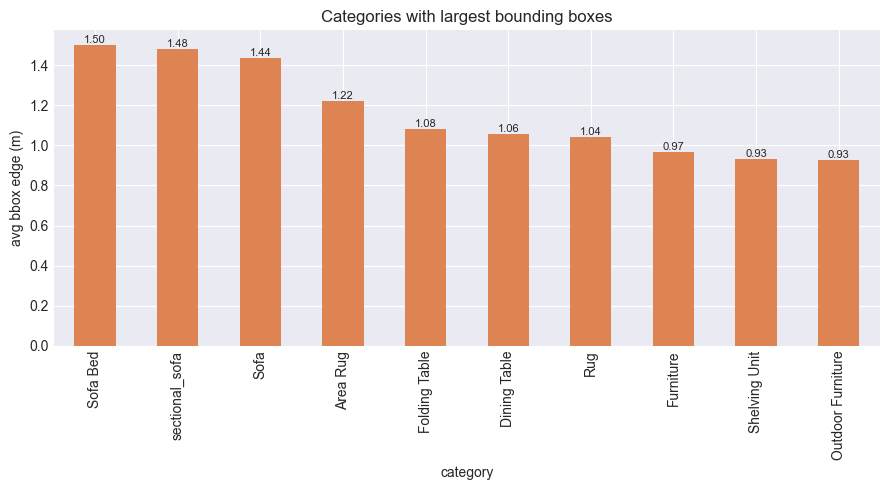

In [13]:
# Show categories with the largest bounding boxes

bbox_stats = (
    df.groupby('category')[['bbox_x', 'bbox_y', 'bbox_z']]
    .agg(['mean', 'std'])
    .round(4)
)
bbox_means = bbox_stats.xs('mean', axis=1, level=1)
bbox_means['mean_size'] = bbox_means.mean(axis=1)
top_bbox = bbox_means.sort_values('mean_size', ascending=False).head(10)
ax = top_bbox['mean_size'].plot(kind='bar', figsize=(9, 5), color='#dd8452')
for patch in ax.patches:
    height = patch.get_height()
    if pd.notnull(height):
        ax.annotate(f"{height:.2f}", (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=8)
ax.set_ylabel('avg bbox edge (m)')
ax.set_title('Categories with largest bounding boxes')
plt.tight_layout()
plt.show()


In [14]:
# Flag assets whose bbox dimensions are statistical outliers
bbox_cols = ['bbox_x', 'bbox_y', 'bbox_z']
z_scores = df.groupby('category')[bbox_cols].transform(
    lambda col: (col - col.mean()) / col.std(ddof=0)
)
df['bbox_outlier'] = z_scores.abs().max(axis=1) > 3
outliers = df[df['bbox_outlier']]
outliers[['asset', 'category', 'bbox_x', 'bbox_y', 'bbox_z']].head(20)

,asset,category,bbox_x,bbox_y,bbox_z
110,coffee_table_51,coffee_tables,1.1430,0.6604,0.1270
140,floor_lamps_2,Lighting,0.2286,1.8034,0.2286
172,recliners_1,recliners,0.7808,1.7326,0.4001
219,recliners_53,recliners,2.1336,0.5080,0.6350
226,recliners_6,recliners,0.5000,0.5600,0.7000
234,recliners_67,recliners,0.7750,1.7350,0.8400
256,recliners_87,recliners,0.7750,1.7370,0.8450
423,side_tables_52,side_tables,0.5783,0.4064,0.2921
451,sofa_19,Sofa,2.1080,0.5590,0.1910
463,sofa_4,Furniture,2.1342,1.6764,0.9652


In [15]:
# Detect assets where bbox vs metric ratios fall outside expected range

ratio_min, ratio_max = 0.5, 1.5
ratio_cols = ['bbox_ratio_x', 'bbox_ratio_y', 'bbox_ratio_z']
ratio_flags = df[ratio_cols].lt(ratio_min) | df[ratio_cols].gt(ratio_max)
abnormal_assets = df[ratio_flags.any(axis=1)]
print(f"{len(abnormal_assets)} assets flagged for abnormal bbox ratios ({ratio_min}-{ratio_max})")
abnormal_assets[['asset', 'category', 'bbox_ratio_x', 'bbox_ratio_y', 'bbox_ratio_z']].head(20)


67 assets flagged for abnormal bbox ratios (0.5-1.5)


,asset,category,bbox_ratio_x,bbox_ratio_y,bbox_ratio_z
0,accent_chairs_1,Furniture,1.031250,8.000000,1.000000
4,accent_chairs_13,Furniture,1.031250,8.000000,1.000000
62,chaise_lounge_2,Outdoor Furniture,3.272727,0.305556,1.000000
63,chaise_lounge_3,Outdoor Furniture,3.261986,0.310704,1.000000
92,coffee_table_35,coffee_tables,1.000000,0.483516,1.295455
93,coffee_table_36,coffee_tables,1.000000,2.229167,1.090909
95,coffee_table_38,coffee_tables,1.795960,0.556805,1.000000
96,coffee_table_39,coffee_tables,1.805774,0.553779,1.000000
98,coffee_table_40,coffee_tables,1.808081,0.553073,1.000000
102,coffee_table_44,coffee_tables,1.000000,0.483516,1.295455


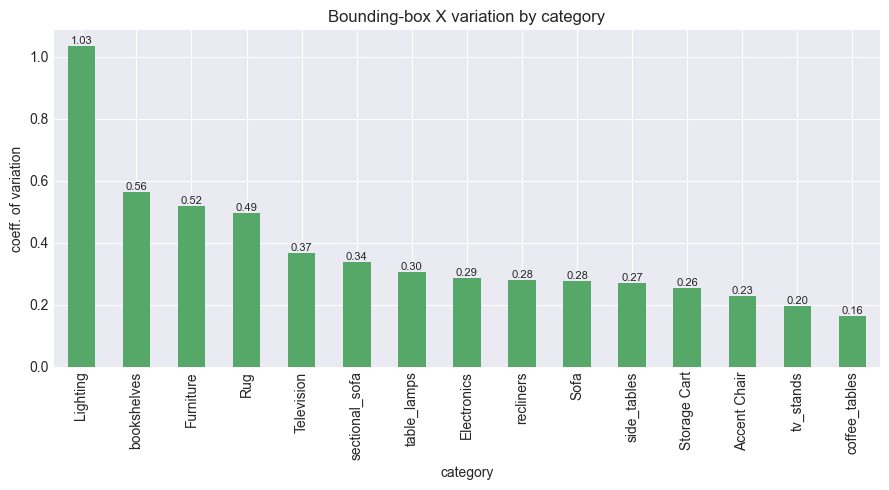

In [16]:
# Plot variation (coefficient of variation) on bbox X per category

variation = (
    df.groupby('category')[['bbox_x', 'bbox_y', 'bbox_z']]
    .std()
    .divide(df.groupby('category')[['bbox_x', 'bbox_y', 'bbox_z']].mean())
    .rename(columns=lambda c: f"{c}_cv")
    .round(3)
)
top_cv = variation['bbox_x_cv'].sort_values(ascending=False).head(15)
ax = top_cv.plot(kind='bar', figsize=(9, 5), color='#55a868')
for patch in ax.patches:
    height = patch.get_height()
    if pd.notnull(height):
        ax.annotate(f"{height:.2f}", (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=8)
ax.set_ylabel('coeff. of variation')
ax.set_title('Bounding-box X variation by category')
plt.tight_layout()
plt.show()


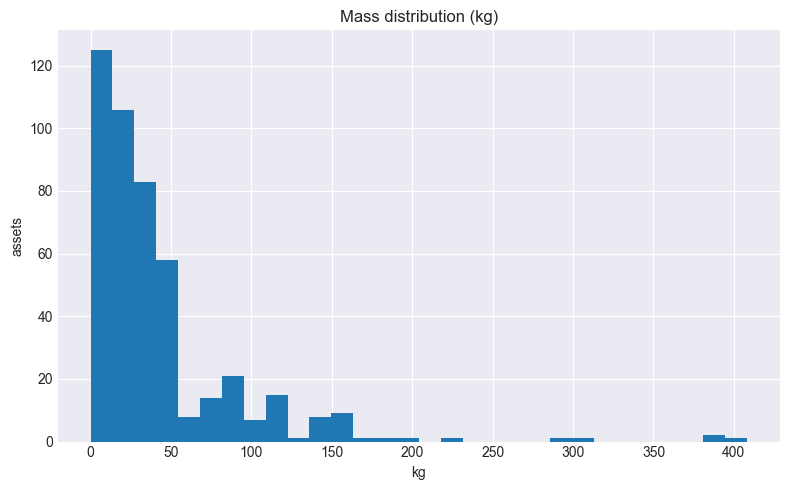

In [17]:
# Inspect overall mass distribution

plt.figure(figsize=(8, 5))
df['mass'].dropna().hist(bins=30)
plt.title('Mass distribution (kg)')
plt.xlabel('kg')
plt.ylabel('assets')
plt.tight_layout()
plt.show()


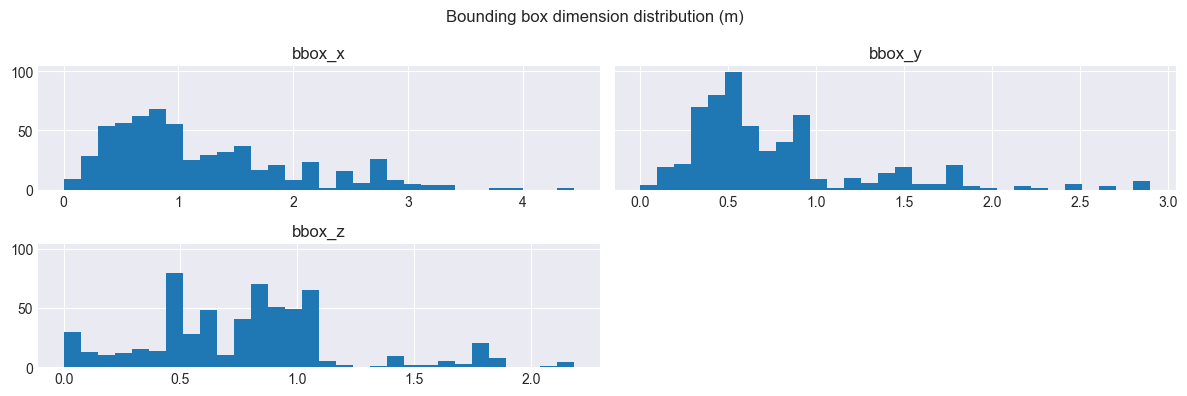

In [18]:
# Inspect bounding-box dimension distributions

bbox_frame = df[['bbox_x', 'bbox_y', 'bbox_z']]
bbox_frame.hist(bins=30, figsize=(12, 4), sharey=True)
plt.suptitle('Bounding box dimension distribution (m)')
plt.tight_layout()
plt.show()


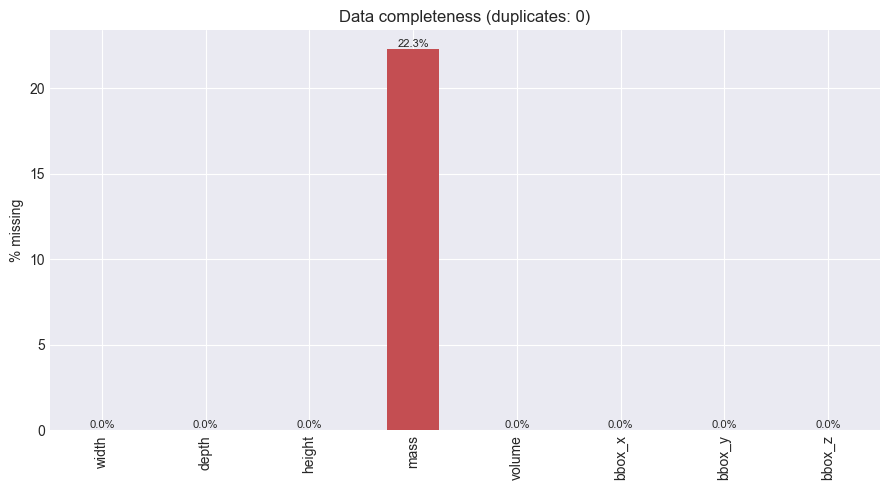

In [19]:
# Visualize missing data percentages and duplicate counts

quality_cols = ['width', 'depth', 'height', 'mass', 'volume', 'bbox_x', 'bbox_y', 'bbox_z']
quality = (
    df[quality_cols]
    .isnull()
    .mean()
    .mul(100)
    .round(2)
)
duplicate_assets = df['asset'].duplicated().sum()
ax = quality.plot(kind='bar', figsize=(9, 5), color='#c44e52')
for patch in ax.patches:
    height = patch.get_height()
    if pd.notnull(height):
        ax.annotate(f"{height:.1f}%", (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=8)
ax.set_ylabel('% missing')
ax.set_title(f'Data completeness (duplicates: {duplicate_assets})')
plt.tight_layout()
plt.show()


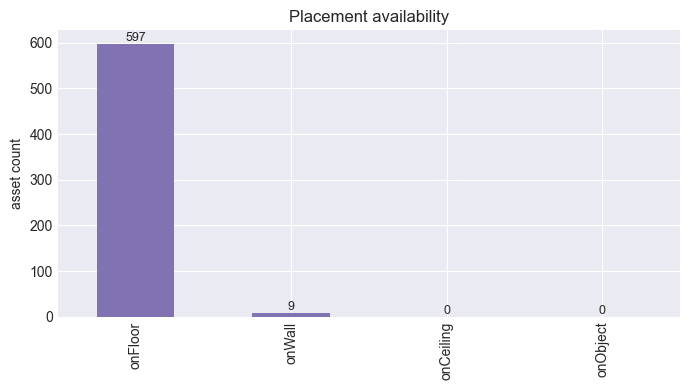

In [20]:
# Plot how many assets support each placement flag

placement = df[['onFloor', 'onWall', 'onCeiling', 'onObject']].sum().sort_values(ascending=False)
ax = placement.plot(kind='bar', figsize=(7, 4), color='#8172b3')
for patch in ax.patches:
    height = patch.get_height()
    ax.annotate(f"{int(height)}", (patch.get_x() + patch.get_width() / 2, height),
                ha='center', va='bottom', fontsize=9)
ax.set_ylabel('asset count')
ax.set_title('Placement availability')
plt.tight_layout()
plt.show()


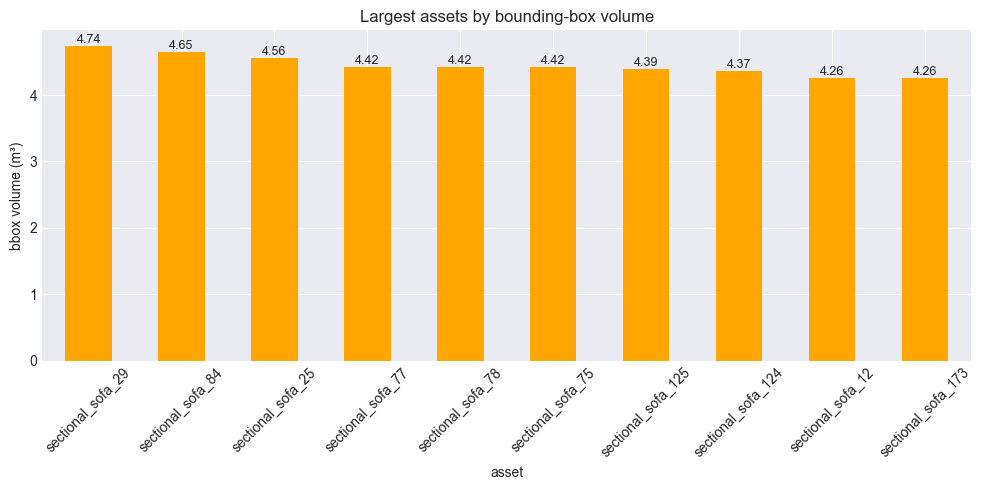

In [23]:
# Highlight assets with the largest bounding-box volumes

largest_assets = (
    df[['asset', 'category', 'bbox_volume']]
    .dropna(subset=['bbox_volume'])
    .sort_values('bbox_volume', ascending=False)
    .head(10)
)
ax = largest_assets.plot(kind='bar', x='asset', y='bbox_volume', legend=False,
                         color='#ffa600', figsize=(10, 5), rot=45)
for patch, category in zip(ax.patches, largest_assets['category']):
    height = patch.get_height()
    ax.annotate(f"{height:.2f}", (patch.get_x() + patch.get_width() / 2, height),
                ha='center', va='bottom', fontsize=9)
ax.set_ylabel('bbox volume (m³)')
ax.set_title('Largest assets by bounding-box volume')
plt.tight_layout()
plt.show()


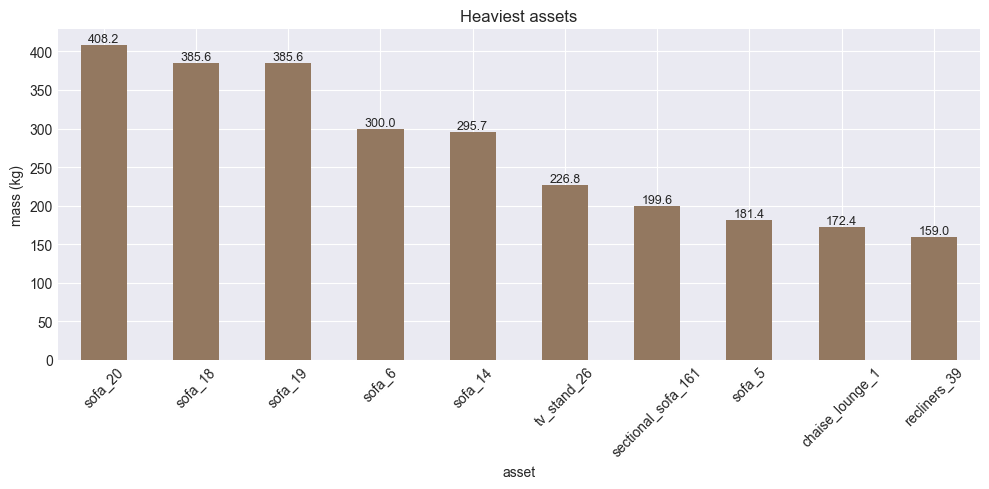

In [24]:
# Highlight the heaviest assets by mass

top_massive = (
    df[['asset', 'category', 'mass']]
    .dropna(subset=['mass'])
    .sort_values('mass', ascending=False)
    .head(10)
)
ax = top_massive.plot(kind='bar', x='asset', y='mass', legend=False, color='#937860', figsize=(10, 5), rot=45)
for patch in ax.patches:
    height = patch.get_height()
    ax.annotate(f"{height:.1f}", (patch.get_x() + patch.get_width() / 2, height),
                ha='center', va='bottom', fontsize=9)
ax.set_ylabel('mass (kg)')
ax.set_title('Heaviest assets')
plt.tight_layout()
plt.show()


In [25]:
# Summarize differences between provided volume and computed volume

df['volume_delta'] = df['volume'] - df['computed_volume']
df['volume_delta'].describe().round(6)


count    597.000000
mean      -0.016967
std        0.084837
min       -0.703132
25%       -0.000035
50%       -0.000000
75%        0.000000
max        0.817087
Name: volume_delta, dtype: float64